# Doc2Vec with K-Means
## Reading data from CSV

In [1]:
import pandas as pd
from gensim.models.doc2vec import TaggedDocument
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns

from src.commons.parse_utils import parse_list_column

In [2]:
csv_file = "../../data/arxiv_processed.csv"
data = pd.read_csv(csv_file, sep=";", converters={'Processed Summary': parse_list_column})

In [3]:
data.head()

,ID,Title,Summary,Published,PDF Link,Processed Summary
0,http://arxiv.org/abs/cs/0002002v1,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,2000-02-03T21:44:57Z,http://arxiv.org/pdf/cs/0002002v1,"[revisit, issue, connection, two, leading, for..."
1,http://arxiv.org/abs/cs/0002003v1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,2000-02-04T12:53:57Z,http://arxiv.org/pdf/cs/0002003v1,"[randomized, algorithm, deciding, satisfiabili..."
2,http://arxiv.org/abs/cs/0002009v1,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,2000-02-16T18:09:20Z,http://arxiv.org/pdf/cs/0002009v1,"[two, different, type, agency, discussed, base..."
3,http://arxiv.org/abs/cs/0003008v1,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,2000-03-05T10:29:03Z,http://arxiv.org/pdf/cs/0003008v1,"[paper, present, method, computing, revision, ..."
4,http://arxiv.org/abs/cs/0003016v1,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,2000-03-07T11:39:53Z,http://arxiv.org/pdf/cs/0003016v1,"[diagnostic, reasoning, characterized, logical..."


## Training Doc2Vec model

In [4]:
from gensim.models import Doc2Vec

tagged_data = [TaggedDocument(words=row['Processed Summary'], tags=[str(index)]) for index, row in data.iterrows()]

model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [5]:
model.save('topic_model')

## Clustering with K-Means

In [6]:
kmeans = KMeans(n_clusters=35, init='k-means++', max_iter=300, n_init=10, random_state=0)

In [7]:
y_kmeans = kmeans.fit_predict(model.dv.vectors)

In [8]:
data['Topic'] = y_kmeans

In [9]:
data.head()

,ID,Title,Summary,Published,PDF Link,Processed Summary,Topic
0,http://arxiv.org/abs/cs/0002002v1,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,2000-02-03T21:44:57Z,http://arxiv.org/pdf/cs/0002002v1,"[revisit, issue, connection, two, leading, for...",11
1,http://arxiv.org/abs/cs/0002003v1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,2000-02-04T12:53:57Z,http://arxiv.org/pdf/cs/0002003v1,"[randomized, algorithm, deciding, satisfiabili...",22
2,http://arxiv.org/abs/cs/0002009v1,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,2000-02-16T18:09:20Z,http://arxiv.org/pdf/cs/0002009v1,"[two, different, type, agency, discussed, base...",31
3,http://arxiv.org/abs/cs/0003008v1,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,2000-03-05T10:29:03Z,http://arxiv.org/pdf/cs/0003008v1,"[paper, present, method, computing, revision, ...",11
4,http://arxiv.org/abs/cs/0003016v1,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,2000-03-07T11:39:53Z,http://arxiv.org/pdf/cs/0003016v1,"[diagnostic, reasoning, characterized, logical...",11


### Visualizing clusters

In [10]:
X_embedded = TSNE(n_components=2).fit_transform(model.dv.vectors)

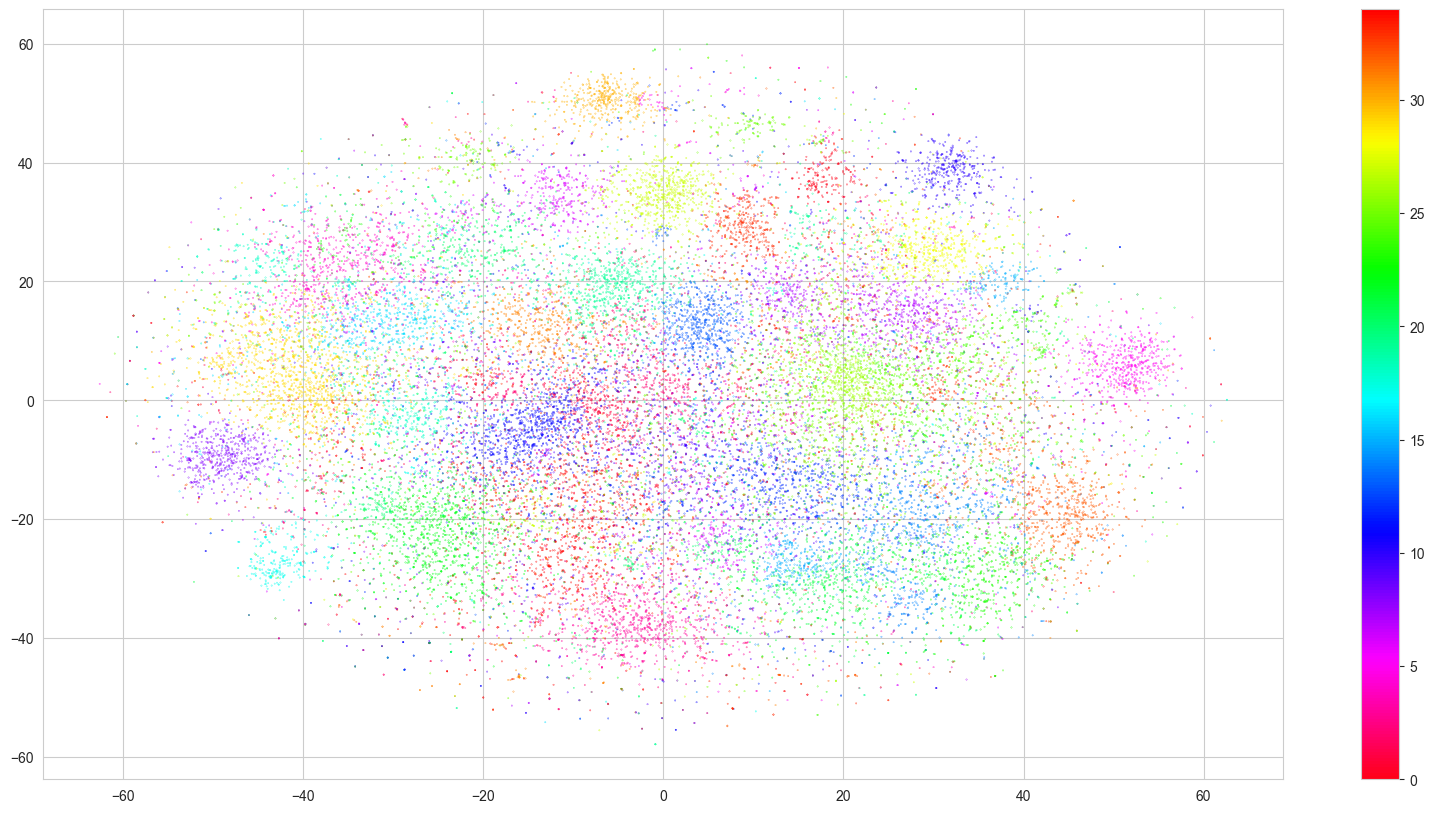

In [11]:
plt.figure(figsize=(20, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_kmeans, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

#### Topic 0 exploration
##### Visualization

In [12]:
topic1_embedded = X_embedded[y_kmeans == 0]

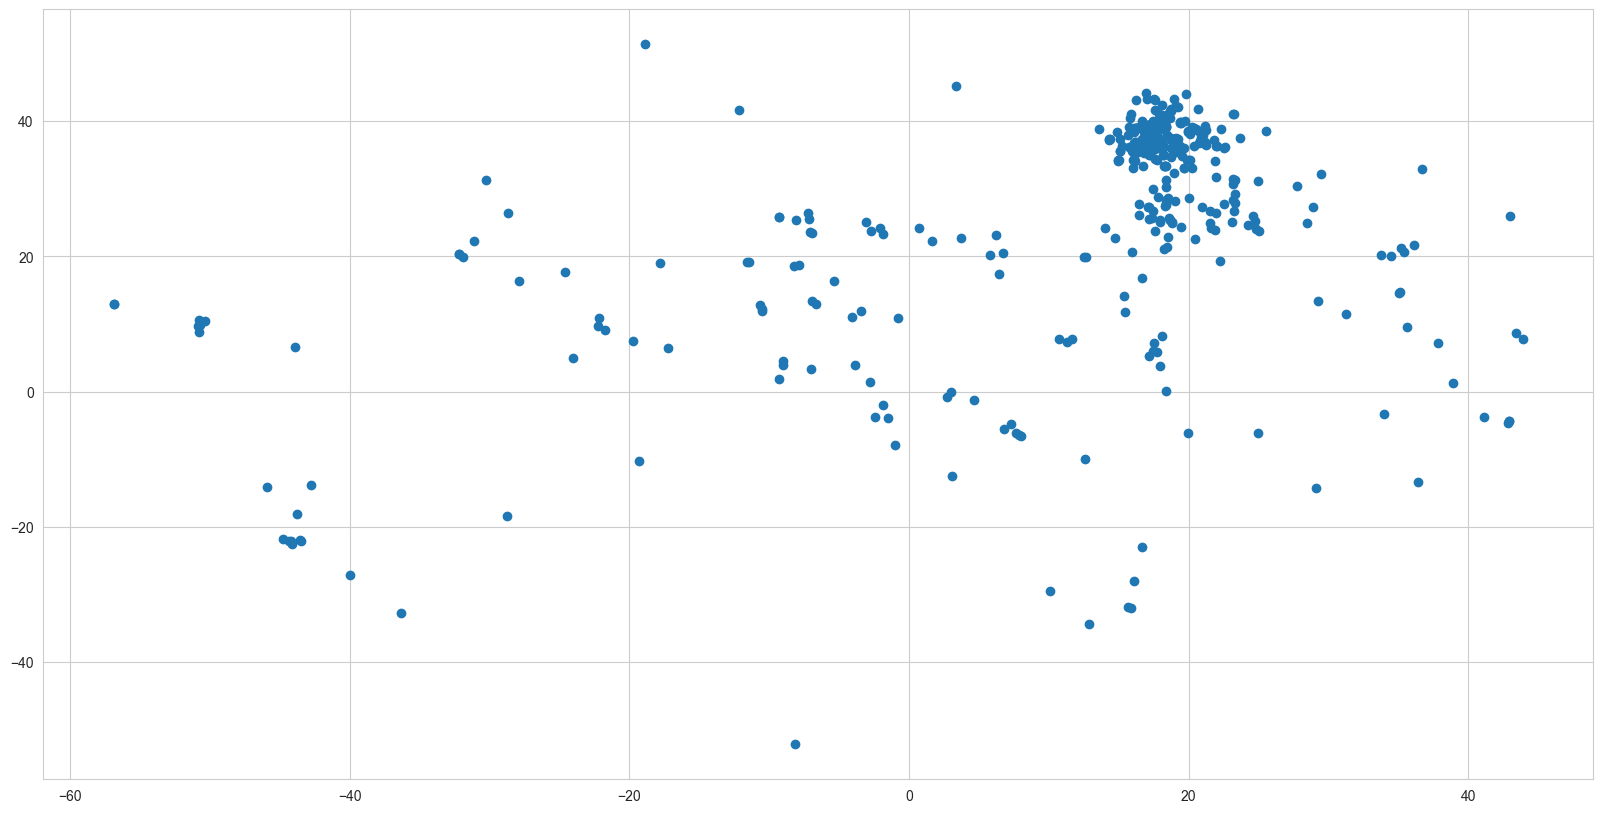

In [13]:
plt.figure(figsize=(20, 10))
plt.scatter(topic1_embedded[:, 0], topic1_embedded[:, 1])
plt.show()

##### Words

In [14]:
processed_summaries = []
for summary in data['Processed Summary']:
    processed_summaries.append(' '.join(summary))

docs_df = pd.DataFrame(processed_summaries, columns=["Doc"])
docs_df['Topic'] = y_kmeans
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [15]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [16]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [17]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
29,29,1595
9,9,1475
22,22,1424
34,34,1372
7,7,1234
24,24,1226
25,25,1203
26,26,1201
11,11,1201
3,3,1148


In [18]:
# topic 0 size
topic_sizes[topic_sizes['Topic'] == 0]

,Topic,Size
0,0,393


In [19]:
top10_words_topic0 =  [i[0] for i in  top_n_words[0][:10]]
print(top10_words_topic0)

['student', 'education', 'teacher', 'course', 'educational', 'teaching', 'ai', 'learner', 'chatgpt', 'feedback']


Some 10 examples summaries from cluster 0:

In [20]:
topic0_docs = data[data['Topic'] == 0]

In [21]:
for index, row in topic0_docs.head(10).iterrows():
    print(f"Document ID: {row['ID']}")
    print(f"Title: {row['Title']}")
    print(f"Summary: {row['Summary']}")
    print(f"Topic: {row['Topic']}")
    print("-" * 80)

Document ID: http://arxiv.org/abs/0809.1077v1
Title: Variable Neighborhood Search for the University Lecturer-Student   Assignment Problem
Summary: The paper presents a study of local search heuristics in general and variable neighborhood search in particular for the resolution of an assignment problem studied in the practical work of universities. Here, students have to be assigned to scientific topics which are proposed and supported by members of staff. The problem involves the optimization under given preferences of students which may be expressed when applying for certain topics.   It is possible to observe that variable neighborhood search leads to superior results for the tested problem instances. One instance is taken from an actual case, while others have been generated based on the real world data to support the analysis with a deeper analysis.   An extension of the problem has been formulated by integrating a second objective function that simultaneously balances the workloa

In [22]:
top10_words_topic10 = [i[0] for i in  top_n_words[10][:10]]
print(top10_words_topic10)

['recommendation', 'user', 'item', 'recommender', 'preference', 'interaction', 'online', 'behavior', 'sequential', 'ranking']


In [23]:
topic10_docs = data[data['Topic'] == 10]

In [24]:
for index, row in topic10_docs.head(10).iterrows():
    print(f"Document ID: {row['ID']}")
    print(f"Title: {row['Title']}")
    print(f"Summary: {row['Summary']}")
    print(f"Topic: {row['Topic']}")
    print("-" * 80)

Document ID: http://arxiv.org/abs/cs/0405030v1
Title: Business Intelligence from Web Usage Mining
Summary: The rapid e-commerce growth has made both business community and customers face a new situation. Due to intense competition on one hand and the customer's option to choose from several alternatives business community has realized the necessity of intelligent marketing strategies and relationship management. Web usage mining attempts to discover useful knowledge from the secondary data obtained from the interactions of the users with the Web. Web usage mining has become very critical for effective Web site management, creating adaptive Web sites, business and support services, personalization, network traffic flow analysis and so on. In this paper, we present the important concepts of Web usage mining and its various practical applications. We further present a novel approach 'intelligent-miner' (i-Miner) to optimize the concurrent architecture of a fuzzy clustering algorithm (to d

In [25]:
for i in range(35):
    print(f"Topic {i} size: {topic_sizes[topic_sizes['Topic'] == i]['Size'].values[0]}")
    print(f"Top 10 words: {[i[0] for i in  top_n_words[i][:10]]}")

Topic 0 size: 393
Top 10 words: ['student', 'education', 'teacher', 'course', 'educational', 'teaching', 'ai', 'learner', 'chatgpt', 'feedback']
Topic 1 size: 1083
Top 10 words: ['belief', 'probability', 'decision', 'theory', 'uncertainty', 'causal', 'preference', 'rule', 'measure', 'evidence']
Topic 2 size: 1022
Top 10 words: ['ontology', 'knowledge', 'research', 'application', 'web', 'development', 'technology', 'software', 'tool', 'service']
Topic 3 size: 1148
Top 10 words: ['pruning', 'architecture', 'quantization', 'parameter', 'memory', 'layer', 'neural', 'accuracy', 'training', 'compression']
Topic 4 size: 932
Top 10 words: ['robot', 'environment', 'object', 'navigation', 'human', 'agent', 'manipulation', 'robotic', 'action', 'behavior']
Topic 5 size: 710
Top 10 words: ['attack', 'adversarial', 'defense', 'security', 'backdoor', 'robustness', 'threat', 'attacker', 'perturbation', 'detection']
Topic 6 size: 948
Top 10 words: ['forecasting', 'prediction', 'traffic', 'series', 'tem

### Topic Trend by quarter

In [26]:
# aggregate the amount of articles per topic per quarter
data['Published'] = pd.to_datetime(data['Published'])
data['Quarter'] = data['Published'].dt.to_period("Q")



C:\Users\Pawel\AppData\Local\Temp\ipykernel_29896\1100420561.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['Quarter'] = data['Published'].dt.to_period("Q")


In [27]:
data['Year'] = data['Published'].dt.year

In [47]:
topic_trend = data.groupby(['Quarter', 'Topic']).size().reset_index(name='Count')


In [48]:
topic_trend.head()

,Quarter,Topic,Count
0,2000Q1,2,2
1,2000Q1,13,14
2,2000Q1,20,2
3,2000Q1,21,1
4,2000Q2,13,2


In [28]:
topic_trend_yr = data.groupby(['Year', 'Topic']).size().reset_index(name='Count')
topic_trend_yr_pivot = topic_trend_yr.pivot(index='Year', columns='Topic', values='Count').fillna(0)
topic_trend_yr_pivot = topic_trend_yr_pivot.sort_index()

In [29]:
# for topic rename to a concatenated string of top 3 words
topic_trend_yr_pivot.columns = [' '.join([word[0] for word in top_n_words[i][:3]]) for i in range(35)]

In [30]:
topic_trend_yr_pivot.head()

,student education teacher,belief probability decision,ontology knowledge research,pruning architecture quantization,robot environment object,attack adversarial defense,forecasting prediction traffic,question answer reasoning,game player agent,process technique event,...,domain target transfer,language translation multilingual,graph node gnns,dialogue response conversation,policy rl reward,client federated fl,cognitive intelligence human,image diffusion generation,entity kg relation,variable function distribution
Year,,,,,,,,,,,,,,,,,,,,,
2000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
2001,0.0,1.0,5.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
2002,0.0,3.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,3.0
2003,0.0,13.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0,9.0,...,0.0,3.0,2.0,1.0,0.0,0.0,4.0,0.0,0.0,3.0
2004,0.0,5.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,15.0,...,0.0,0.0,3.0,0.0,1.0,0.0,15.0,0.0,0.0,2.0


In [49]:
topic_trend_pivot = topic_trend.pivot(index='Quarter', columns='Topic', values='Count').fillna(0)

In [50]:
topic_trend_pivot.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Quarter,,,,,,,,,,,,,,,,,,,,,
2000Q1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000Q2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000Q3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2000Q4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001Q1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
pivoted_data = topic_trend_pivot.sort_index()

In [53]:
import matplotlib.animation as animation

Animation saved as top_topics_over_time.gif


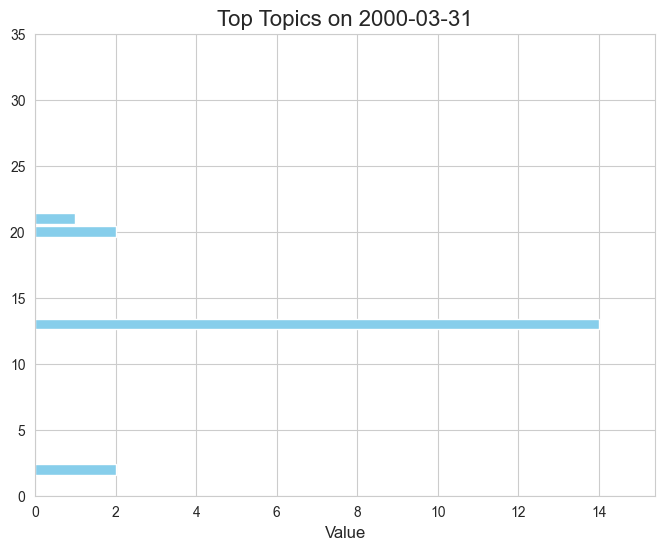

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))

# set y lim to show 0-35
ax.set_ylim(0, 35)

def update(frame):
    ax.clear()
    current_data = pivoted_data.iloc[:frame + 1].iloc[-1]
    current_data = current_data.sort_values(ascending=False)
    current_data = current_data.head(10)  # Show only top 10 topics
    
    ax.barh(current_data.index, current_data.values, color='skyblue')
    ax.set_title(f"Top Topics on {pivoted_data.index[frame].strftime('%Y-%m-%d')}", fontsize=16)
    ax.set_xlabel('Value', fontsize=12)
    ax.set_xlim(0, current_data.max() * 1.1)
    ax.set_ylim(0, 35)
    
ani = animation.FuncAnimation(fig, update, frames=len(pivoted_data), interval=500)

# Save as GIF
output_gif_path = 'top_topics_over_time.gif'
ani.save(output_gif_path, writer='pillow', fps=10)

print(f"Animation saved as {output_gif_path}")

In [58]:
!pip install bar_chart_race

In [31]:
import bar_chart_race as bcr

In [64]:
bcr.bar_chart_race(df=pivoted_data, filename='topic_trend.gif', n_bars=10, title='Top 10 Topics by Quarter')

C:\Users\Pawel\AppData\Local\Programs\Python\Python310\lib\site-packages\bar_chart_race\_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
C:\Users\Pawel\AppData\Local\Programs\Python\Python310\lib\site-packages\bar_chart_race\_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))
C:\Users\Pawel\AppData\Local\Programs\Python\Python310\lib\site-packages\bar_chart_race\_make_chart.py:226: UserWarning: Some of your columns never make an appearance in the animation. To reduce color repetition, set `filter_column_colors` to `True`
  warnings.warn("Some of your columns never make an appearance in the animation. "
MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\Pawel\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted witho

In [40]:
bcr.bar_chart_race(df=topic_trend_yr_pivot, 
                   filename='topic_trend.gif', 
                   n_bars=10, 
                   title='Top 10 Topics by Year', 
                   interpolate_period=True, 
                   steps_per_period=40, 
                   period_fmt='{x:10.2f}',
                   period_length=2000)

C:\Users\Pawel\AppData\Local\Programs\Python\Python310\lib\site-packages\bar_chart_race\_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
C:\Users\Pawel\AppData\Local\Programs\Python\Python310\lib\site-packages\bar_chart_race\_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))
C:\Users\Pawel\AppData\Local\Programs\Python\Python310\lib\site-packages\bar_chart_race\_make_chart.py:226: UserWarning: Some of your columns never make an appearance in the animation. To reduce color repetition, set `filter_column_colors` to `True`
  warnings.warn("Some of your columns never make an appearance in the animation. "
MovieWriter imagemagick unavailable; using Pillow instead.


In [38]:
val = 20.137
print(f"val:,.0f")

val:,.0f


### Topic Trend by year


In [26]:
data['Year'] = pd.to_datetime(data['Published']).dt.year

In [27]:
topic_trend = data.groupby(['Year', 'Topic']).size().reset_index(name='Count')

In [28]:
topic_trend.head()

,Year,Topic,Count
0,2000,0,1
1,2000,2,2
2,2000,7,2
3,2000,12,1
4,2000,13,20


In [28]:
topic_trend_pivot = topic_trend.pivot(index='Year', columns='Topic', values='Count').fillna(0)

In [29]:
topic_trend_pivot.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Year,,,,,,,,,,,,,,,,,,,,,
2000,2.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,22.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0
2002,3.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0,34.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0
2003,3.0,2.0,4.0,3.0,0.0,1.0,1.0,2.0,23.0,1.0,...,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,10.0,0.0
2004,2.0,2.0,4.0,6.0,1.0,1.0,3.0,2.0,15.0,2.0,...,0.0,1.0,3.0,4.0,0.0,0.0,3.0,0.0,7.0,0.0


Normalize it by number of articles in year

In [30]:
# Normalize topic_trend_pivot by number of articles in year
total_articles_per_year = topic_trend_pivot.sum(axis=1)

topic_trend_pivot_normalized = topic_trend_pivot.div(total_articles_per_year, axis=0)

topic_trend_pivot_normalized.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Year,,,,,,,,,,,,,,,,,,,,,
2000,0.054054,0.027027,0.027027,0.027027,0.000000,0.000000,0.054054,0.000000,0.594595,0.000000,...,0.0,0.027027,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2001,0.030303,0.060606,0.030303,0.000000,0.000000,0.030303,0.000000,0.000000,0.181818,0.000000,...,0.0,0.000000,0.000000,0.151515,0.0,0.0,0.030303,0.030303,0.000000,0.0
2002,0.044118,0.000000,0.029412,0.000000,0.000000,0.014706,0.044118,0.000000,0.500000,0.014706,...,0.0,0.000000,0.000000,0.029412,0.0,0.0,0.014706,0.000000,0.044118,0.0
2003,0.038462,0.025641,0.051282,0.038462,0.000000,0.012821,0.012821,0.025641,0.294872,0.012821,...,0.0,0.000000,0.012821,0.064103,0.0,0.0,0.012821,0.000000,0.128205,0.0
2004,0.019417,0.019417,0.038835,0.058252,0.009709,0.009709,0.029126,0.019417,0.145631,0.019417,...,0.0,0.009709,0.029126,0.038835,0.0,0.0,0.029126,0.000000,0.067961,0.0


In [31]:
from sklearn.preprocessing import MinMaxScaler

# Normalize topic_trend_pivot_normalized to 0-1 range
scaler = MinMaxScaler()
topic_trend_pivot_normalized_0_1 = pd.DataFrame(scaler.fit_transform(topic_trend_pivot_normalized),
                                                index=topic_trend_pivot_normalized.index,
                                                columns=topic_trend_pivot_normalized.columns)

topic_trend_pivot_normalized_0_1.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Year,,,,,,,,,,,,,,,,,,,,,
2000,0.412181,0.445946,0.306306,0.232432,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.0,0.783140,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2001,0.201809,1.000000,0.377778,0.000000,0.000000,0.491717,0.000000,0.000000,0.288632,0.000000,...,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.643939,0.719488,0.000000,0.0
2002,0.324170,0.000000,0.358333,0.000000,0.000000,0.238627,0.816176,0.000000,0.836978,0.380788,...,0.0,0.000000,0.000000,0.194118,0.0,0.0,0.312500,0.000000,0.237379,0.0
2003,0.274072,0.423077,0.835470,0.330769,0.000000,0.208034,0.237179,0.630789,0.483466,0.331969,...,0.0,0.000000,0.264902,0.423077,0.0,0.0,0.272436,0.000000,0.689820,0.0
2004,0.105391,0.320388,0.563916,0.500971,0.119405,0.157540,0.538835,0.477685,0.226268,0.502789,...,0.0,0.281322,0.601817,0.256311,0.0,0.0,0.618932,0.000000,0.365672,0.0


<Axes: xlabel='Year'>

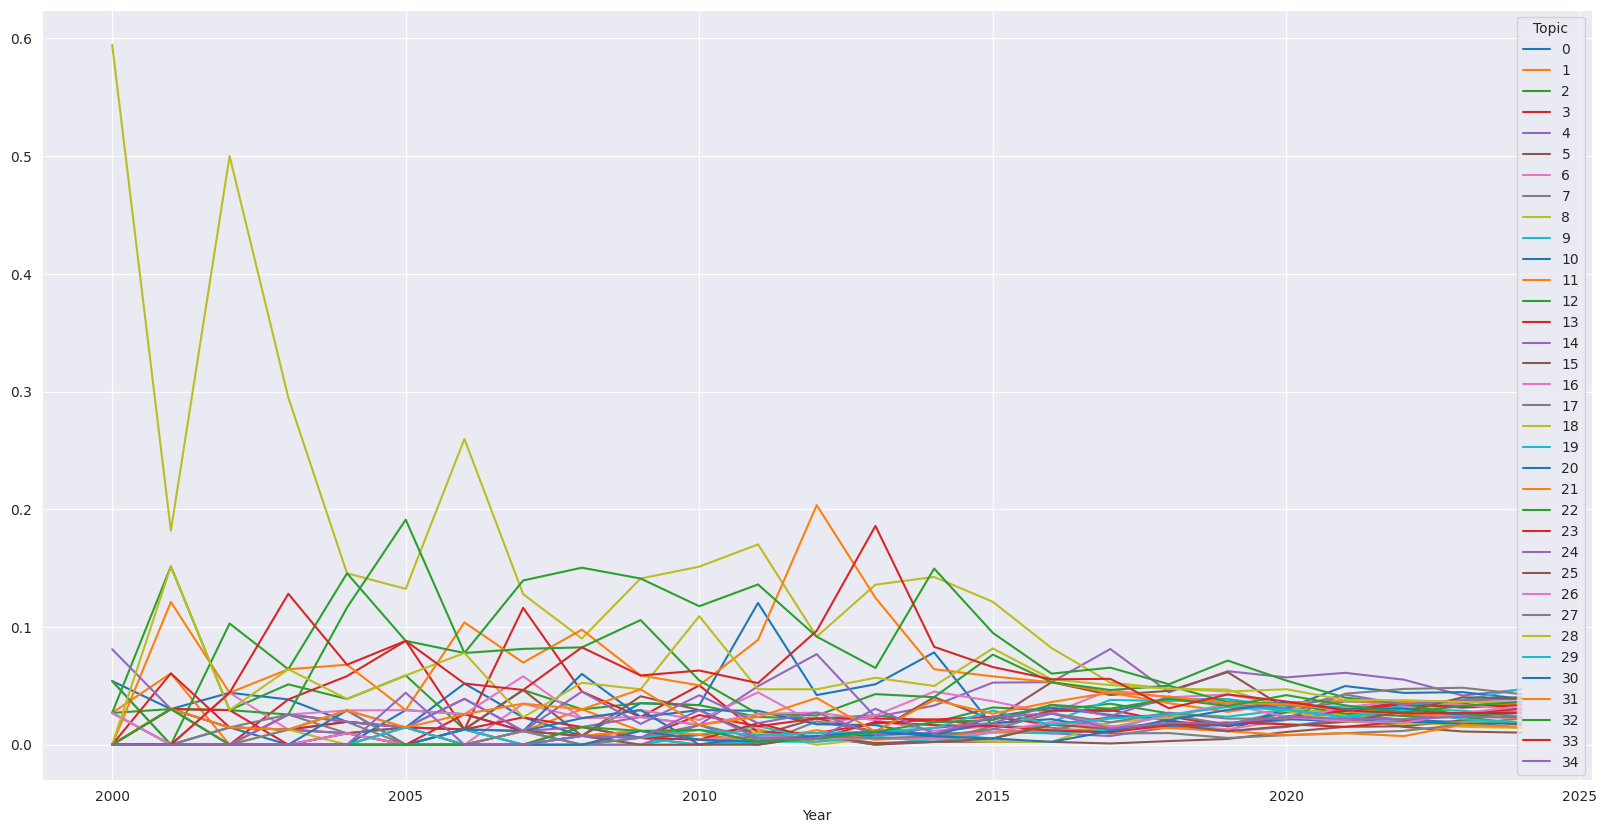

In [32]:
topic_trend_pivot_normalized.plot(kind='line', figsize=(20, 10))

<Axes: xlabel='Year'>

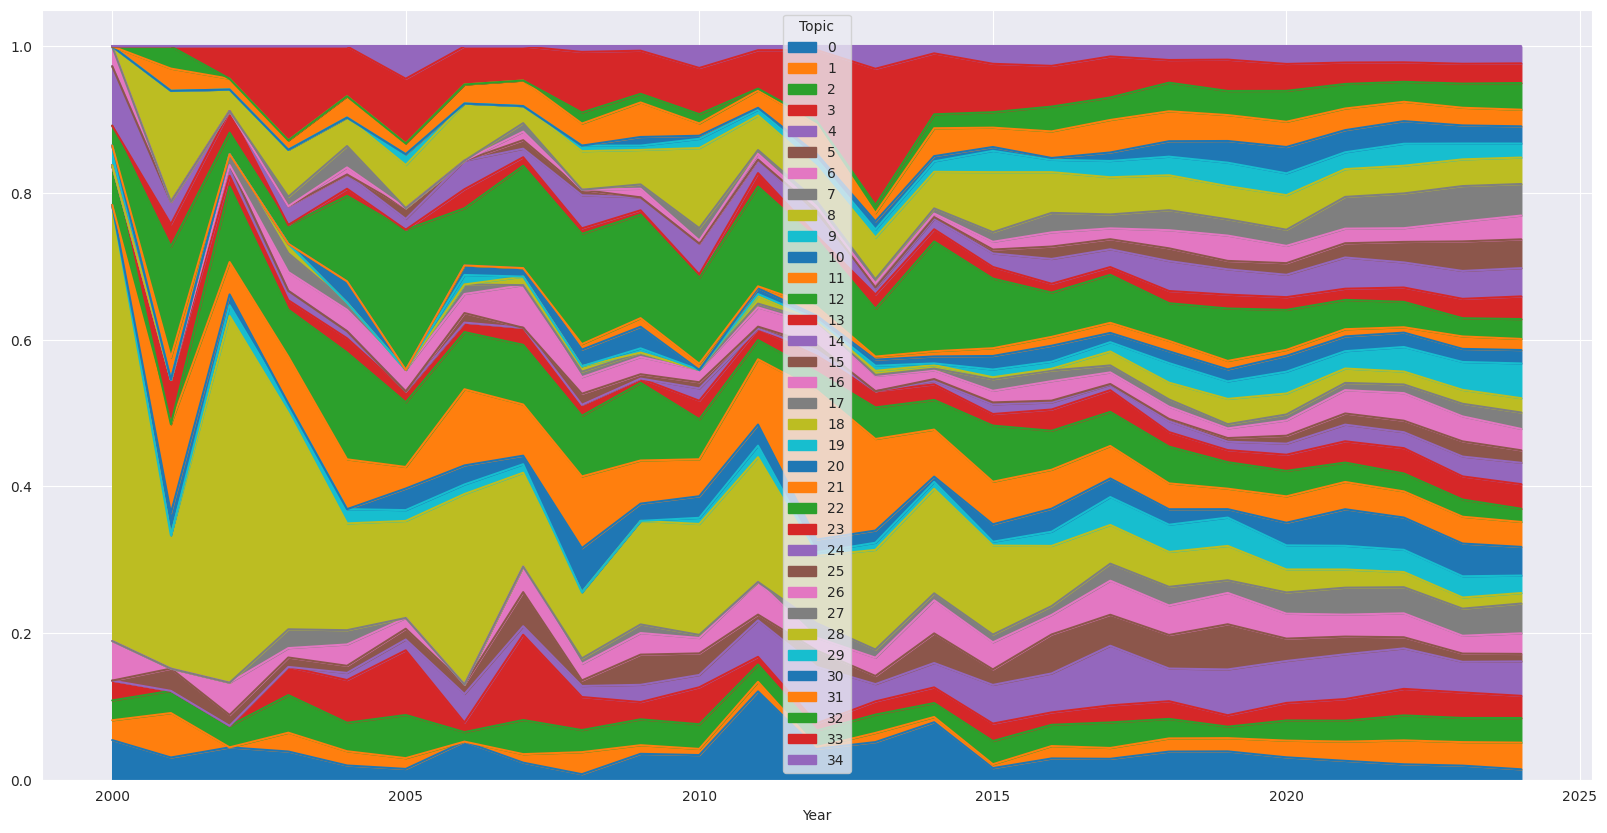

In [33]:
topic_trend_pivot_normalized.plot(kind='area', figsize=(20, 10))

<Axes: xlabel='Year'>

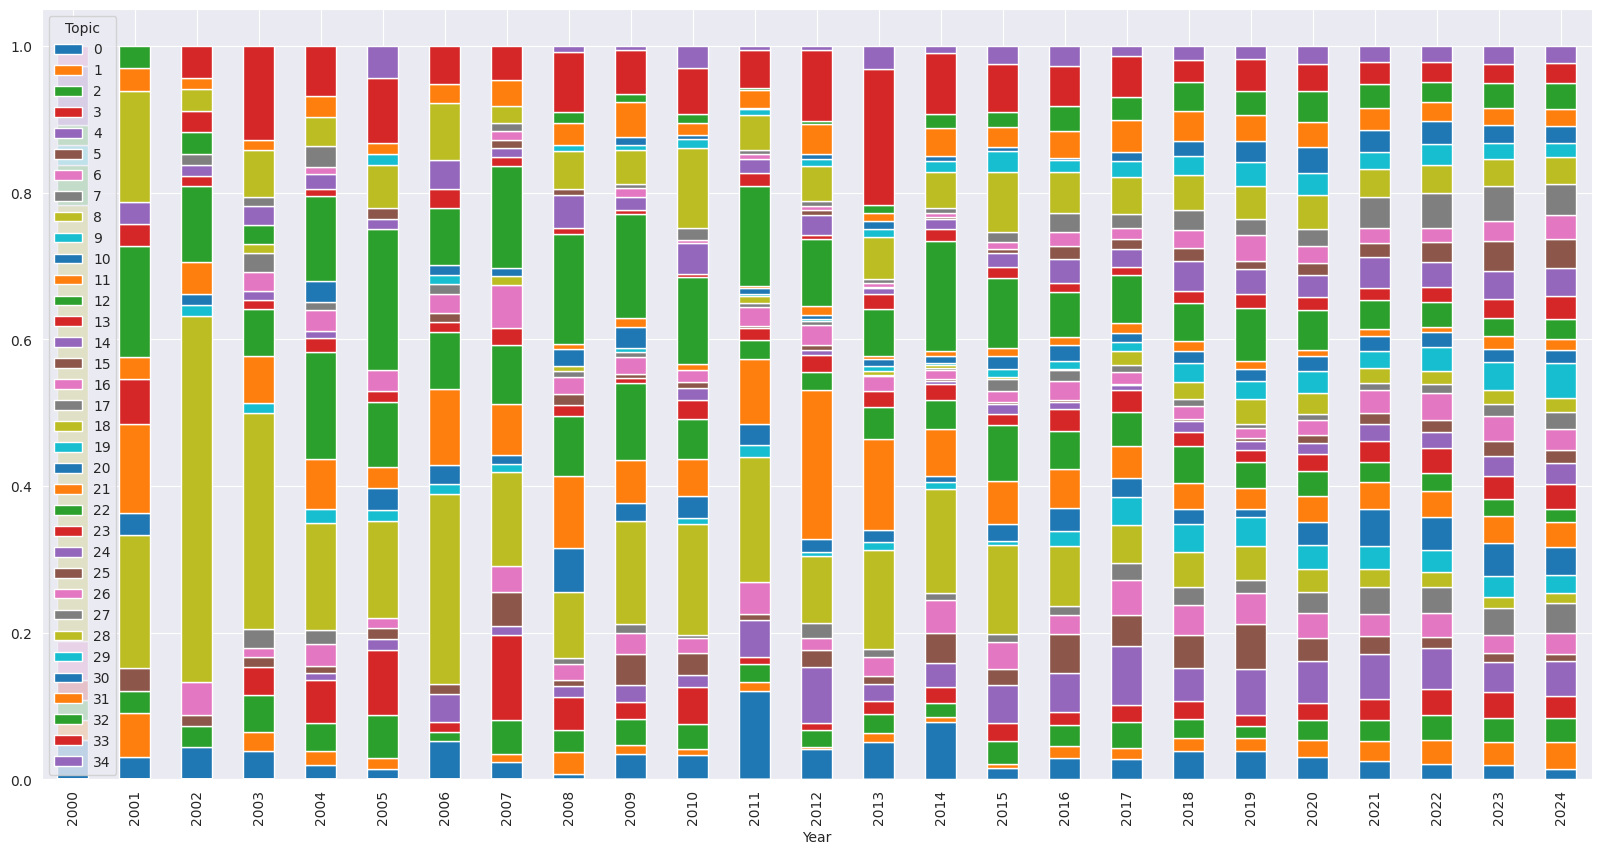

In [34]:
topic_trend_pivot_normalized.plot(kind='bar', stacked=True, figsize=(20, 10))

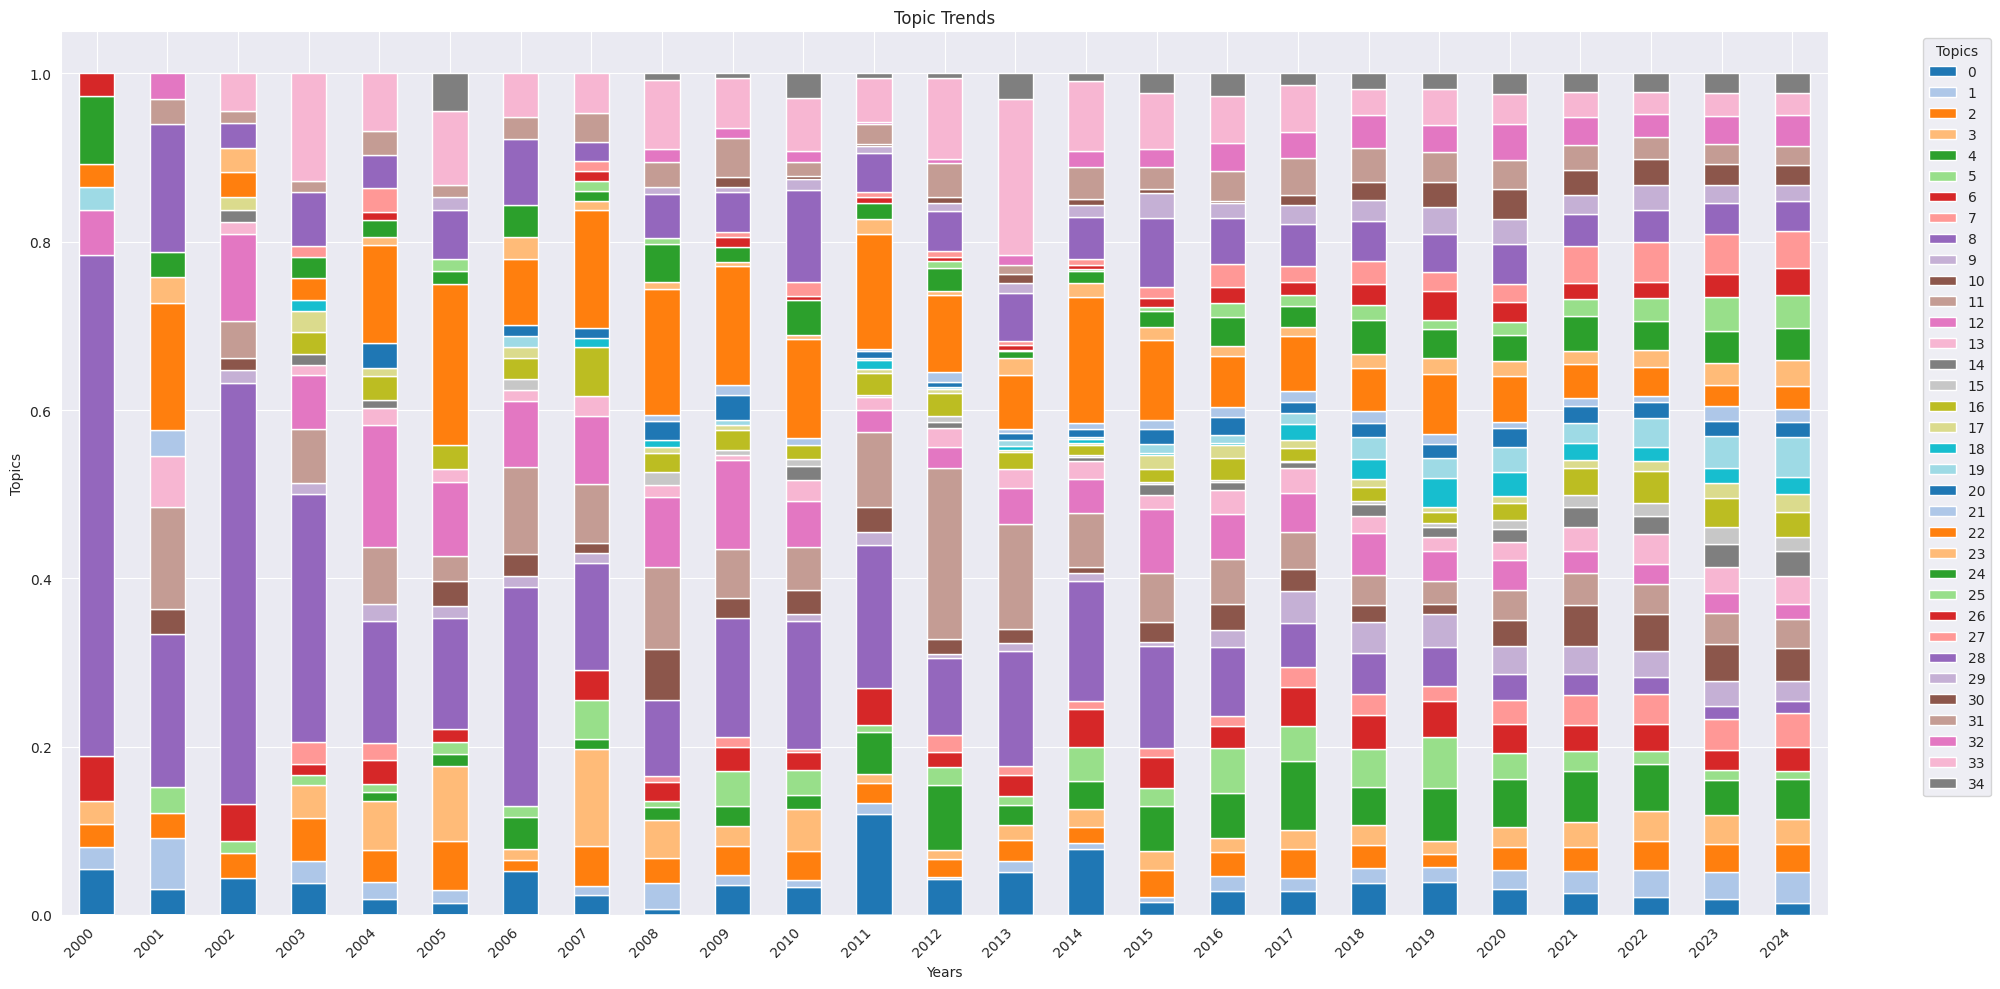

In [35]:
num_topics = len(topic_trend_pivot_normalized.columns)
palette = sns.color_palette("tab20", n_colors=num_topics)

# Plot
fig, ax = plt.subplots(figsize=(max(20, num_topics * 0.5), 10))  # Adjust width dynamically
topic_trend_pivot_normalized.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 10),
    ax=ax,
    color=palette
)

# Adjust legend
ax.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve readability of the x-axis labels
plt.xticks(rotation=45, ha='right')

# Add title and labels
plt.title("Topic Trends")
plt.xlabel("Years")
plt.ylabel("Topics")

plt.tight_layout()
plt.show()

<Axes: xlabel='Year'>

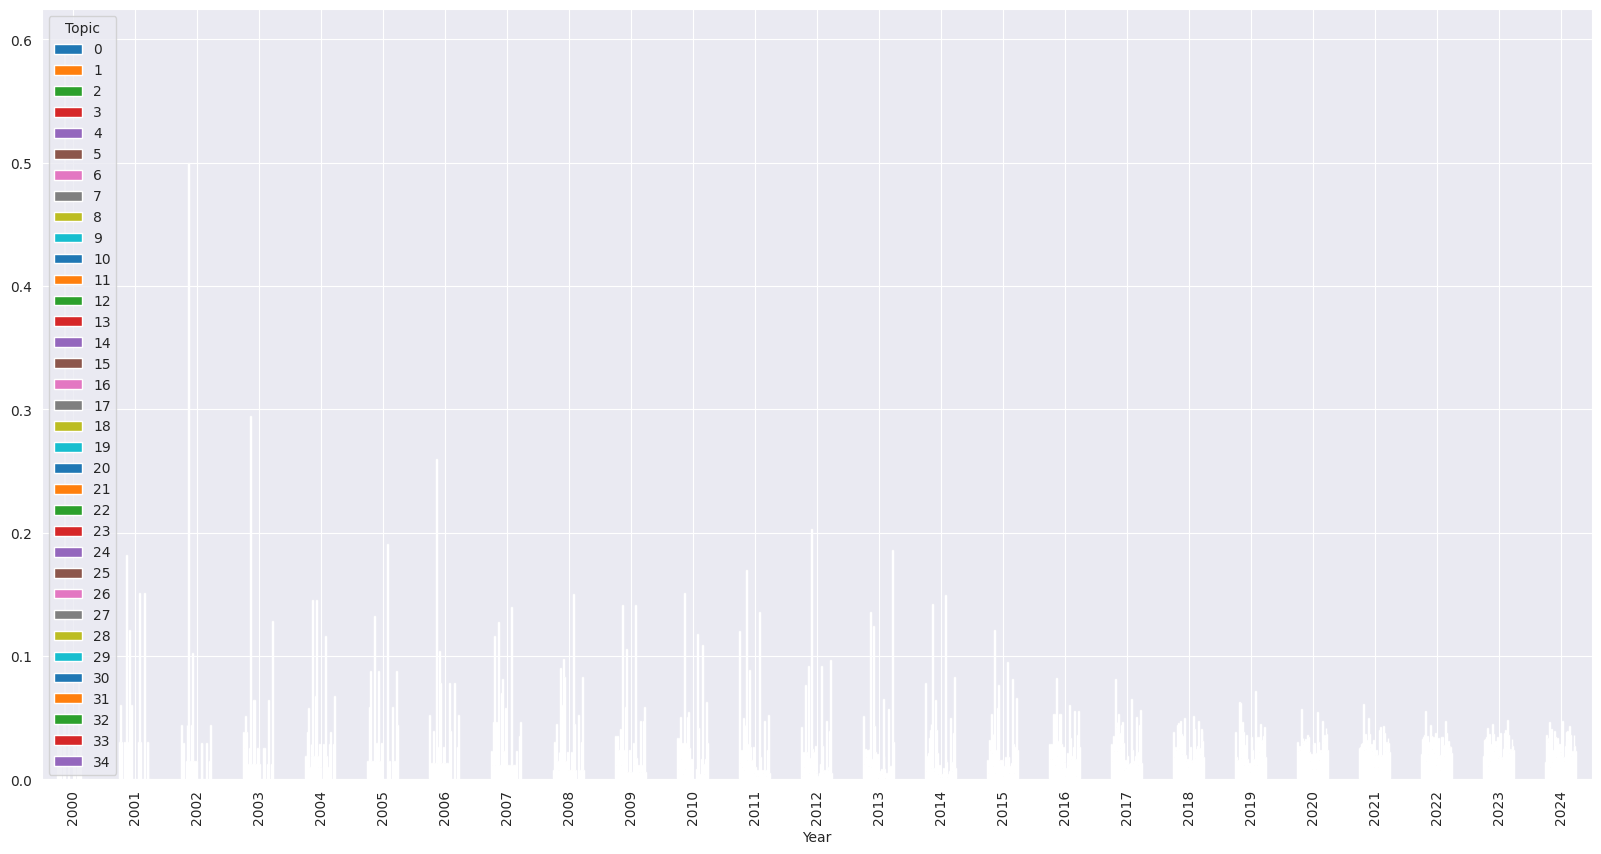

In [36]:
topic_trend_pivot_normalized.plot(kind='bar', figsize=(20, 10))

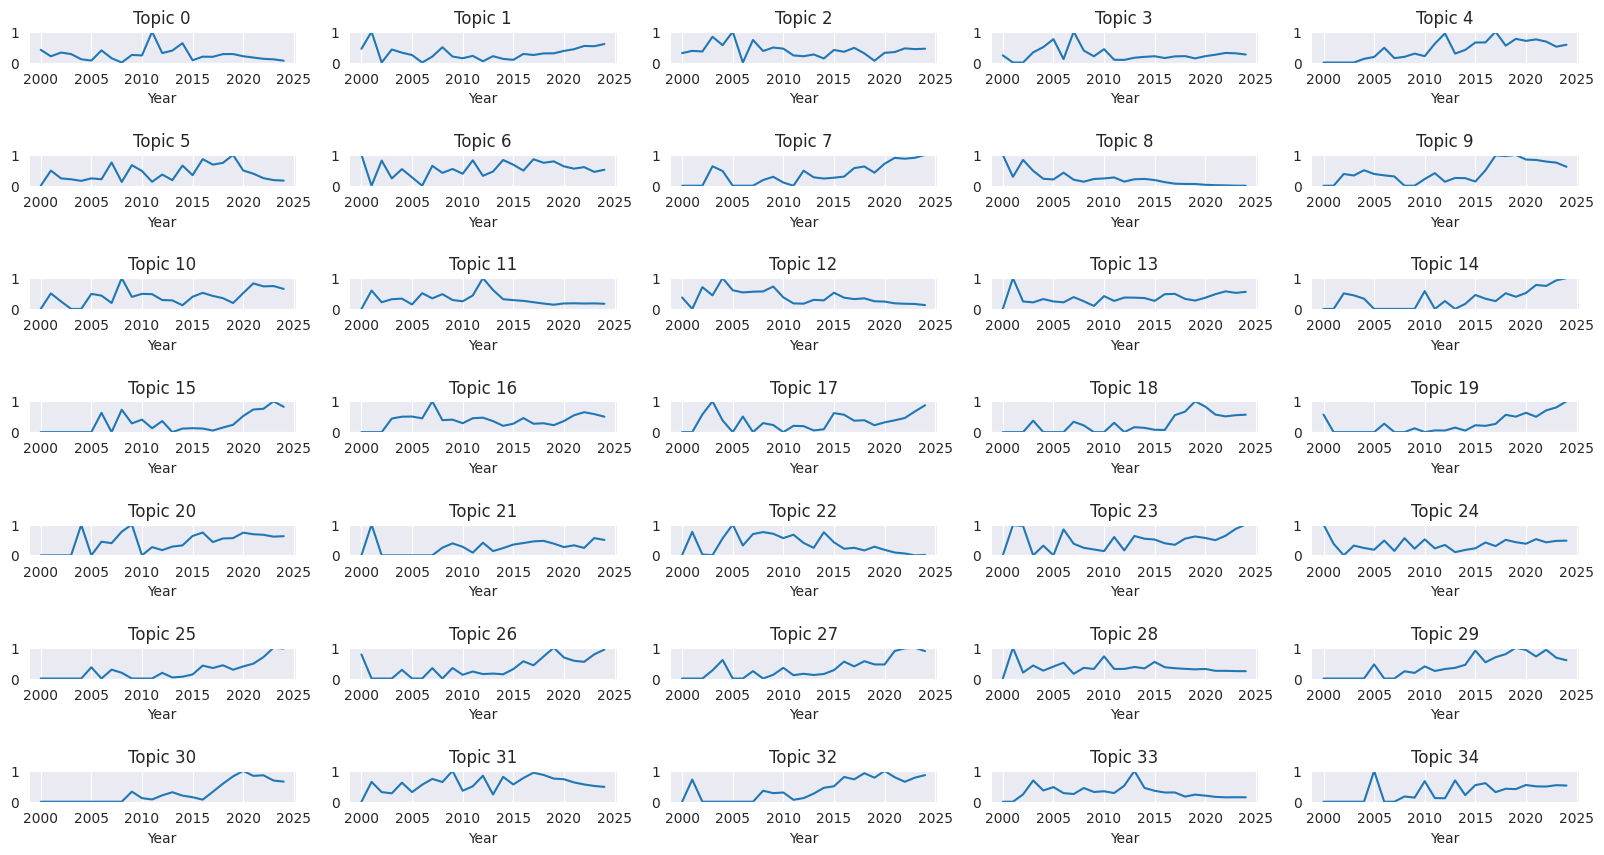

In [37]:
y_min = topic_trend_pivot_normalized_0_1.min().min()
y_max = topic_trend_pivot_normalized_0_1.max().max()

fig, axs = plt.subplots(7, 5, figsize=(20, 10))
for i in range(35):
    topic_trend_pivot_normalized_0_1[i].plot(ax=axs[i//5, i%5], title=f"Topic {i}")
    axs[i//5, i%5].set_ylim(y_min, y_max)  # Set the same y-axis limits for each subplot

plt.subplots_adjust(hspace=3)  # Adjust the height space between rows
plt.show()

### Metrics

In [27]:
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity, InvertedRBO
from octis.evaluation_metrics.similarity_metrics import PairwiseJaccardSimilarity
from octis.evaluation_metrics.topic_significance_metrics import KL_uniform, KL_vacuous, KL_background

In [22]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words_list = [top_n_words[i] for i in range(len(top_n_words))]
top_n_words_list = [[tuple[0] for tuple in topic] for topic in top_n_words_list]
top_n_words_list

[['cognitive',
  'intelligence',
  'human',
  'brain',
  'artificial',
  'theory',
  'machine',
  'concept',
  'computational',
  'ai',
  'neural',
  'consciousness',
  'cognition',
  'ability',
  'biological',
  'intelligent',
  'world',
  'computer',
  'memory',
  'mechanism',
  'reasoning',
  'computing',
  'processing',
  'architecture',
  'understanding',
  'symbolic',
  'neuron',
  'structure',
  'evolution',
  'general'],
 ['vehicle',
  'traffic',
  'service',
  'control',
  'scheduling',
  'management',
  'resource',
  'energy',
  'routing',
  'demand',
  'solution',
  'network',
  'transportation',
  'simulation',
  'optimization',
  'time',
  'communication',
  'dynamic',
  'cost',
  'optimal',
  'reinforcement',
  'route',
  'environment',
  'operation',
  'road',
  'algorithm',
  'urban',
  'device',
  'smart',
  'power'],
 ['pruning',
  'architecture',
  'quantization',
  'memory',
  'parameter',
  'layer',
  'neural',
  'training',
  'accuracy',
  'network',
  'weight',
 

In [34]:
# calculate probability that document belongs to topic
centroids = kmeans.cluster_centers_
doc_embeddings = model.dv.vectors

In [35]:
from scipy.spatial.distance import cdist

distances = cdist(doc_embeddings, centroids, 'euclidean')
distances.shape

(34427, 35)

In [36]:
beta = 1.0
weights = np.exp(-beta * distances.T)
weights /= weights.sum(axis=0)

print("N x D Weights Matrix:")
print(weights)

N x D Weights Matrix:
[[0.03709201 0.02542859 0.05122558 ... 0.02384894 0.01693581 0.02119294]
 [0.0168009  0.02543819 0.03144763 ... 0.01885514 0.03281076 0.01874805]
 [0.02286068 0.02692566 0.03023985 ... 0.02667353 0.02741977 0.03594149]
 ...
 [0.01620563 0.02178477 0.01887679 ... 0.01966811 0.03070559 0.10190948]
 [0.01932747 0.01854288 0.01950319 ... 0.018374   0.03085618 0.03280102]
 [0.01899943 0.01881252 0.03510596 ... 0.0271902  0.02565787 0.02075257]]


In [39]:
model_output = dict()
model_output['topics'] = top_n_words_list
model_output['topic-word-matrix'] = tf_idf
model_output["topic-document-matrix"] = weights

In [23]:
from octis.dataset.dataset import Dataset

dataset = Dataset()
dataset.load_custom_dataset_from_folder("../../data/octis")

In [30]:
def calculate_metrics(model_output, dataset, topk=10, verbose=False):
    umass = Coherence(texts=dataset.get_corpus(), topk=topk, measure='u_mass')
    npmi = Coherence(texts=dataset.get_corpus(), topk=topk, measure='c_npmi')
    c_v = Coherence(texts=dataset.get_corpus(), topk=topk, measure='c_v')
    topic_diversity = TopicDiversity(topk=topk)
    inv_rbo = InvertedRBO(topk=topk)
    pairwise_jaccard = PairwiseJaccardSimilarity()
    kl_uniform = KL_uniform()
    kl_vacuous = KL_vacuous()
    kl_background = KL_background()
    metrics = [(umass, 'UMass'), (npmi, 'NPMI'), (c_v, 'C_V'), (topic_diversity, 'Topic Diversity'), (inv_rbo, 'Inverted RBO'), (pairwise_jaccard, 'Pairwise Jaccard'), (kl_uniform, 'KL Uniform'), (kl_vacuous, 'KL Vacuous'), (kl_background, 'KL Background')]
    results = dict()
    for metric, name in metrics:
        try:
            metric_score = metric.score(model_output)
        except:
            metric_score = None
        finally:
            if verbose:
                print(f"{name}: {metric_score}")
            results[name] = metric_score
    return results


In [40]:
metrics = calculate_metrics(model_output, dataset, verbose=True)

UMass: -2.1131777616836716
NPMI: 0.13781809652979066
C_V: 0.6912939261181982
Topic Diversity: 0.7314285714285714
Inverted RBO: 0.9858515674127731
Pairwise Jaccard: 0.011876928273889522
KL Uniform: 2.8718009898330283
KL Vacuous: 9.261963992200151
KL Background: 0.03844930283161817
